In [114]:
import numpy as np
import time
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import TimeDistributed, Dense, Flatten,ConvLSTM2D,RepeatVector
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf 
from keras import backend as k 


from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Conv2D, Flatten, Dense, TimeDistributed, ConvLSTM2D, RepeatVector

In [115]:
df1=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno1/eplusout/eplusout.csv')
df2=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno2/eplusout/eplusout.csv')
df3=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/anno3/eplusout/eplusout.csv')

In [116]:
def changetime(df,year):
    datetimeform = []
    for i in range(len(df.index)):
        tt = df["Date/Time"][i]
        days, hours = tt.split('  ')
        tt = f'{days.split("/")[1]}/{days.split("/")[0]}/{year}{hours}'
        tt = tt.replace(' ', '')
        if '201724:' or '201824:' or '201924:' in tt:
            tt=tt.replace('24:', '00:')
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            timestamp += 86400
            #timestamp = datetime.fromtimestamp(timestamp)

        else:
            timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
            #timestamp = datetime.fromtimestamp(timestamp)
        datetimeform.append(timestamp)

    df["TimeStep"]=datetimeform
    
changetime(df1,"2017")
changetime(df2,"2018")
changetime(df3,"2019")
df1.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),TimeStep
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491085e+09
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491086e+09
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1.491087e+09


#Extract mean temp time series
#mean value of the 3 indoor zones
def meanDF(df):
    df_mean = pd.DataFrame()
    #"Date/Time",\
    #"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
    #"Electricity:Facility [J](TimeStep)"
    df_mean = df[[
              "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
              "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
              ]]
    df_temp=df_mean.copy()
    df_temp.dropna(inplace=True)
    df_temp["mean"] = df_temp.mean(1)


    df_final=pd.DataFrame()
    df_final["DateTime"] = df["TimeStep"]
    df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
    df_final["Indoor_Mean"] = df_temp["mean"]
    df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
    df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
    df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
    
    #df_final
    return df_final

df1_final=meanDF(df1)
df2_final=meanDF(df2)
df3_final=meanDF(df3)
df1_final.head()

In [117]:
# selecting only the values to train the rnn on 
x = pd.DataFrame()
meas = [
        #"TimeStep",
        "DistrictCooling:Facility [J](TimeStep)",
        "Electricity:Facility [J](TimeStep)",
        "Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
        "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)",
        "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",
        "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)"]

#x["Indoor_Mean"] = pd.concat([df1_final["Indoor_Mean"],df2_final["Indoor_Mean"],df3_final["Indoor_Mean"]])

for m in meas:
    x[m]=pd.concat([df1[m],df2[m],df3[m]])
#x.set_index("TimeStep",inplace=True)
#x.head()
x.reset_index(inplace=True,drop=True)


In [118]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DistrictCooling:Facility [J](TimeStep),79056.0,631011.612780,470880.141620,0.000000,192920.550912,554914.507292,1.050636e+06,1.905375e+06
Electricity:Facility [J](TimeStep),79056.0,130616.658843,159314.651387,27449.355191,27449.355191,27449.355191,3.394476e+05,5.384741e+05
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),79056.0,24.359656,5.218590,6.200000,21.095833,24.800000,2.830000e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,283.717416,335.925819,0.000000,0.000000,47.000000,6.553333e+02,9.190000e+02
Environment:Site Wind Speed [m/s](TimeStep),79056.0,3.948260,2.656548,0.000000,1.900000,3.350000,5.600000e+00,1.650000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),79056.0,101022.317768,348.420867,99682.000000,100792.833333,101100.000000,1.012970e+05,1.022000e+05
Environment:Site Wind Direction [deg](TimeStep),79056.0,209.793672,88.844315,0.000000,171.666667,216.666667,2.800000e+02,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),79056.0,80.631622,90.721616,0.000000,0.000000,51.000000,1.455000e+02,5.320000e+02
BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON),79056.0,25.303998,0.957111,21.200759,24.373144,26.000000,2.600000e+01,2.799143e+01
BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON),79056.0,25.846067,0.461588,22.035929,26.000000,26.000000,2.600000e+01,2.600000e+01


In [119]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [123]:

range(x.shape[1]*n_in+1,x.shape[1]*n_in+x.shape[1])

range(67, 77)

In [124]:
n_in = 6
n_out = 2
reframed = series_to_supervised(x.to_numpy(), n_in, n_out)
reframed.drop(reframed.columns[range(x.shape[1]*n_in+1,x.shape[1]*n_in+x.shape[1])], axis=1, inplace=True)
reframed.head()
#reframed.shape

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var8(t-6),var9(t-6),var10(t-6),...,var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var8(t+1),var9(t+1),var10(t+1),var11(t+1)
6,0.0,27449.355191,15.433333,0.0,3.0,101250.666667,19.166667,0.0,23.680708,24.583088,...,27449.355191,10.133333,0.0,2.366667,101394.0,327.333333,0.0,23.040820,24.007935,24.455883
7,0.0,27449.355191,14.366667,0.0,2.9,101280.333333,8.333333,0.0,23.570734,24.486530,...,27449.355191,10.150000,0.0,2.300000,101391.5,328.500000,0.0,23.020177,23.975804,24.417294
8,0.0,27449.355191,13.300000,0.0,2.8,101310.000000,357.500000,0.0,23.452511,24.386547,...,27449.355191,10.166667,0.0,2.233333,101389.0,329.666667,0.0,22.994148,23.938246,24.375290
9,0.0,27449.355191,12.233333,0.0,2.7,101339.666667,346.666667,0.0,23.340556,24.291091,...,27449.355191,10.183333,0.0,2.166667,101386.5,330.833333,0.0,22.965884,23.898981,24.329205
10,0.0,27449.355191,11.166667,0.0,2.6,101369.333333,335.833333,0.0,23.232600,24.196600,...,27449.355191,10.200000,0.0,2.100000,101384.0,332.000000,0.0,22.938289,23.860835,24.282723


In [125]:
# Split dataset into train, validation and test and normalize data

ntot = reframed.shape[0]
values = reframed.values

#first two years for training 
x_train = values[:(len(df1)+len(df2)), :]
#x_train.set_index("TimeStep",inplace=True)
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

x_val =  values[(len(df1)+len(df2)): (len(df1)+len(df2)) + int(0.5*len(df3)), :]
#x_val.set_index("TimeStep",inplace=True)
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  values[(len(df1)+len(df2)) + int(0.5*len(df3)):, :]
#x_test.set_index("TimeStep",inplace=True)
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

train_X, train_y = x_train_norm[:, :-1],  x_train_norm[:, -1]
test_X, test_y = x_test_norm[:, :-1],  x_test_norm[:, -1]

#TODO: CAPIRE QUESTE DUE RIGHE PRECEDENTI

Training set dimension:  52704
Validation set dimension:  13176
Test set dimension:  13169


In [126]:
def bi_lstm_model():
	model = Sequential()
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
	model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
	model.add(TimeDistributed(Flatten()))
	model.add(Bidirectional(LSTM(64, activation='relu',return_sequences=True)))
	model.add(Bidirectional(LSTM(64, activation='relu')))
	model.add(Dense(128))
	model.add(Dropout(0.5))
	model.add(Dense(1))
	model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
	return model 

In [130]:
#CNN-Bi-LSTM 
#n_steps, n_features = train_X.shape[1], train_X.shape[2]
n_features = 1 #da predirre
n_seq = 1
n_steps = 11*(n_in+1)

train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))

#Define Model
model = bi_lstm_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 76, 64)      192       
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 38, 64)      0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 37, 64)      8256      
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 18, 64)      0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 1152)        0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         623104    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 128)              

In [131]:
history = model.fit(train_X, train_y, epochs=15, batch_size=30, validation_data=(test_X, test_y), verbose=1)

Epoch 1/15
1757/1757 [==============================] - 27s 13ms/step - loss: 0.0028 - mae: 0.0298 - mse: 0.0028 - mape: 8.5921 - val_loss: 1.2931e-06 - val_mae: 0.0011 - val_mse: 1.2931e-06 - val_mape: 0.3217
Epoch 2/15
1757/1757 [==============================] - 23s 13ms/step - loss: 1.1050e-04 - mae: 0.0080 - mse: 1.1050e-04 - mape: 2.3141 - val_loss: 3.7746e-07 - val_mae: 6.0206e-04 - val_mse: 3.7746e-07 - val_mape: 0.1737
Epoch 3/15
1757/1757 [==============================] - 24s 14ms/step - loss: 1.4359e-06 - mae: 8.4793e-04 - mse: 1.4359e-06 - mape: 0.2447 - val_loss: 9.5579e-09 - val_mae: 8.2927e-05 - val_mse: 9.5579e-09 - val_mape: 0.0239
Epoch 4/15
1757/1757 [==============================] - 25s 14ms/step - loss: 1.4509e-08 - mae: 8.8611e-05 - mse: 1.4509e-08 - mape: 0.0256 - val_loss: 4.2314e-09 - val_mae: 5.5283e-05 - val_mse: 4.2314e-09 - val_mape: 0.0160
Epoch 5/15
1757/1757 [==============================] - 25s 15ms/step - loss: 7.7892e-08 - mae: 1.6693e-04 - mse: 7.

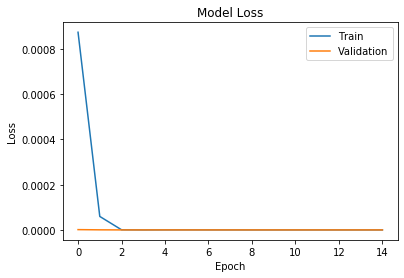

In [132]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [133]:
# make a prediction
yhat = model.predict(test_X)
print(test_X.shape)
#test_X = test_X.reshape((test_X.shape[0], 11))

(13169, 1, 77, 1)


In [134]:
pred_denorm = [t*std+mean for t in yhat]
pred_df = pd.DataFrame(pred_denorm)

In [135]:
test_denorm = [t*std+mean for t in test_y]
test = pd.DataFrame(test_denorm)

Text(0.5, 1.0, 'DistrictCooling Facility Prediction')

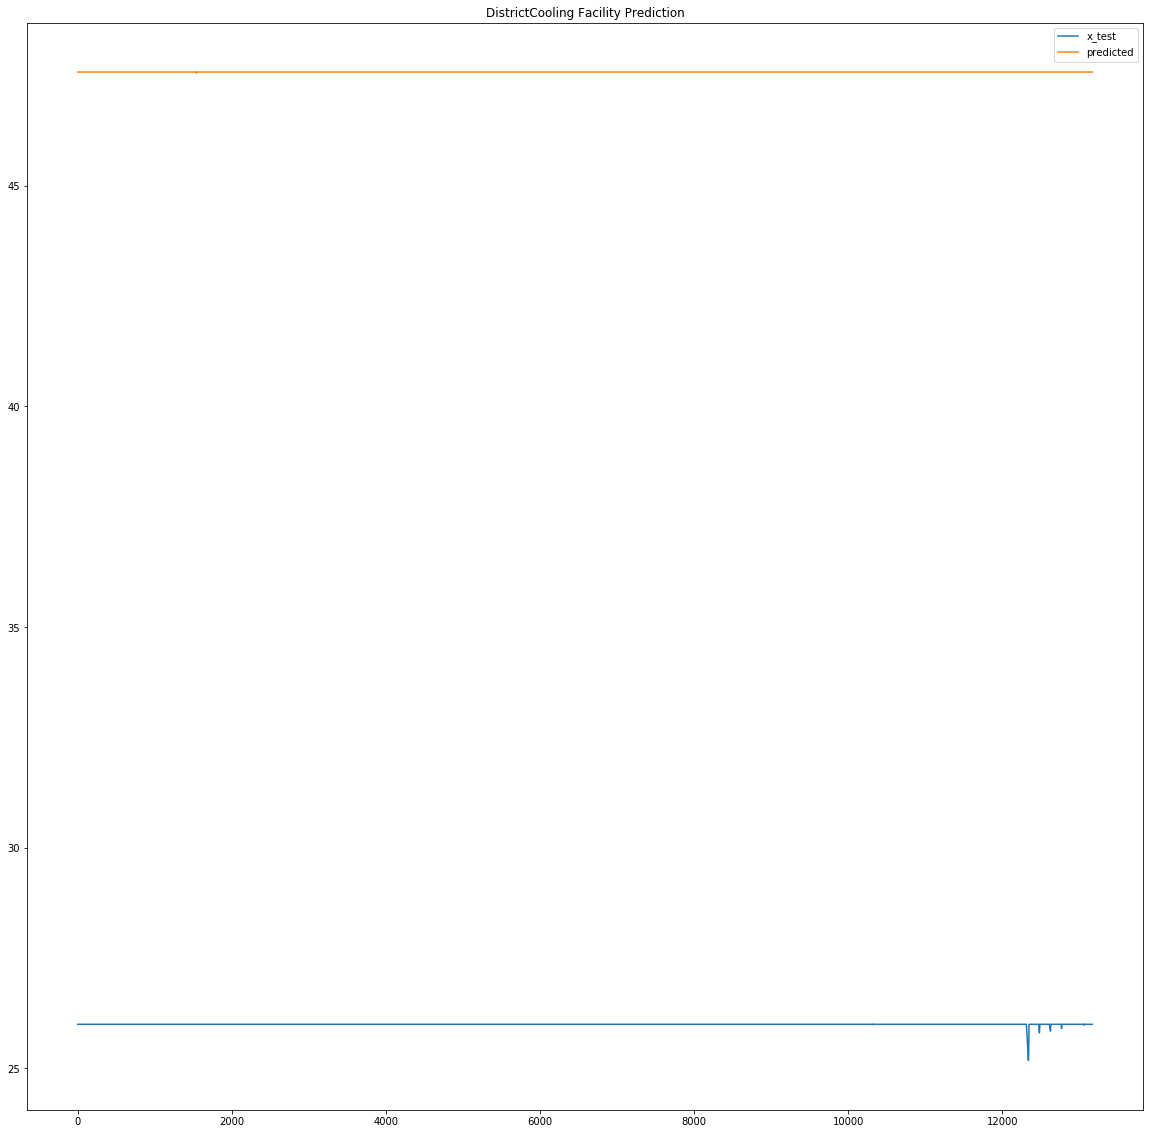

In [140]:
plt.figure(figsize=(20,20))
plot_test = test_y.copy()
#plot_test.reset_index(inplace=True,drop=True)
plt.plot(test)
plt.plot(pred_df)
plt.legend(['x_test','predicted'])
plt.title("DistrictCooling Facility Prediction")
#print(plot_test[4:])
#print(pred_df[0:8])
#plot_test.reset_index(inplace=True,drop=True)
#print(plot_t.shape)
#print(pred_df.shape)

In [137]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [138]:
def calculate_metrics(inv_y,inv_yhat):
	# calculate metrics
	rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
	mse = mean_squared_error(inv_y, inv_yhat)
	mae = mean_absolute_error(inv_y, inv_yhat)
	mape = mean_absolute_percentage_error(inv_y, inv_yhat)
	return rmse, mse, mae, mape

In [139]:
rmse, mse, mae, mape = calculate_metrics(test, pred_df)

print("Test MSE: %.3f"%mse)
print('Test RMSE: %.3f' % rmse)
print("Test MAE: %.3f" % mae)
#print("Test MAPE: %.3f" % mape)

Test MSE: 465.676
Test RMSE: 21.580
Test MAE: 21.580


In [ ]:
## 'neurons': 12

# Total window size: 8 -> Input indices: [0 1 2 3 4 5] Label indices: [6 7]
# loss: 0.0151 - mean_absolute_percentage_error: 36.4191 - rmse: 89737.6441121866

# Total window size: 12 -> Input indices: [0 1 2 3 4 5] Label indices: [ 6  7  8  9 10 11]
# loss: 0.0378 - mean_absolute_percentage_error: 75.3893 - rmse: 165518.73420347186

# Total window size: 16 -> Input indices: [0 1 2 3 4 5 6 7 8 9] Label indices: [10 11 12 13 14 15]
# loss: 0.0358 - mean_absolute_percentage_error: 58.4344 - rmse: 168050.95017360165

# Total window size: 16 -> Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11] Label indices: [12 13 14 15]
# loss: 0.0278 - mean_absolute_percentage_error: 71.6392 - rmse: 140321.72971796765

# Total window size: 18 -> Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11] Label indices: [12 13 14 15 16 17]
# loss: 0.0356 - mean_absolute_percentage_error: 84.7530 - rmse: 176186.70476650228


## 

# Total window size: 216 (144 inputs, 72 outputs)
# 


